In [122]:
from AutoDL_ingestion_program.dataset import AutoNLPDataset
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import jieba

from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch.autograd as autograd

### Fun Utils

In [114]:
def clean_en_text(dat):

    REPLACE_BY_SPACE_RE = re.compile('["/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')

    ret = []
    for line in dat:
        # text = text.lower() # lowercase text
        line = REPLACE_BY_SPACE_RE.sub(' ', line)
        line = BAD_SYMBOLS_RE.sub('', line)
        line = line.strip()
        ret.append(line)
    return ret

def clean_zh_text(dat):
    REPLACE_BY_SPACE_RE = re.compile('[“”【】/（）：！～「」、|，；。"/(){}\[\]\|@,\.;]')

    ret = []
    for line in dat:
        line = REPLACE_BY_SPACE_RE.sub(' ', line)
        line = line.strip()
        ret.append(line)
    return ret


def _tokenize_chinese_words(text):
    return ' '.join(jieba.cut(text, cut_all=False))

## Get Data

In [123]:
autoDaset = AutoNLPDataset('offline_data/O1/O1.data')
autoDaset.read_dataset()

In [124]:
x_data, y_data = autoDaset.get_train()

In [125]:
# take a look at the what the data look like
print(x_data[:5])
print(y_data[:5])

['a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films \n', 'apparently reassembled from the cutting-room floor of any given daytime soap . \n', "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes . \n", 'this is a visually stunning rumination on love , memory , history and the war between art and commerce . \n', "jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films . \n"]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [126]:
num_class = autoDaset.get_metadata()['class_num']
print('number of classes : ', num_class)

number of classes :  2


## Data pre-processing

- The data has many punctuations, we can replace it by space.

- There is not valid set, so we will split the whole dataset into transet ans valid set to better generate the training and hyper-parameters.

- Each observation is a sentence which is hard to translated into presentation, we will split it to tokens.

- We will convert data to Pytorch tensors so they can be used in a neural network. To do that, you must first create a dictionnary that will map words to integers. Add to the dictionnary only words that are in the training set

clean sentences

In [127]:

if autoDaset.get_metadata()['language'] == 'ZH':
    x_data = clean_zh_text(x_data)
    x_data = list(map(_tokenize_chinese_words, x_data))
else:
    x_data = clean_en_text(x_data)

In [128]:
print('number of transet : ', len(x_data))

number of transet :  7792


tokenize dataset

In [129]:
x_data = list(map(word_tokenize, x_data))
x_data[0]

['a',
 'stirring',
 'funny',
 'and',
 'finally',
 'transporting',
 'reimagining',
 'of',
 'beauty',
 'and',
 'the',
 'beast',
 'and',
 '1930s',
 'horror',
 'films']

Split into train set and valid set

In [10]:
# split data into transet and valset
X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=True)

In [11]:
print('N X_train : ', len(X_train))
print('N X_val : ', len(X_val))

N X_train :  6233
N X_val :  1559


In [12]:
# onhot encode to category
def ohe2cat(label):
    return np.argmax(label, axis=1)
Y_train, Y_val = ohe2cat(Y_train), ohe2cat(Y_val)

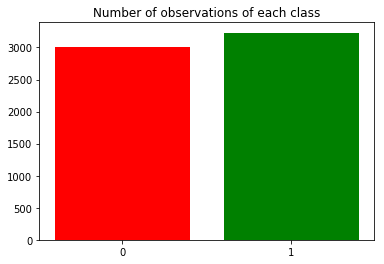

In [13]:
## compute number of occurence of each class

class_name = [i for i in range(num_class)]
class_n = [np.sum(Y_train==class_name[i])  for i in range(num_class)]

plt.bar(range(num_class), class_n,color='rgb',tick_label=class_name)
plt.title('Number of observations of each class')
plt.show()

## it is balanced, good

Create a dictionnary that will map words to integers

In [96]:
dictionary = {}
num_voc = 0
for sentence in X_train:
    for word in sentence:
        if word not in dictionary.keys():
            dictionary[word] = num_voc
            num_voc += 1
dictionary['UNK'] = num_voc
num_voc+=1

In [97]:
def to_tensor(data):
    d = []
    for word in data:
        if word in dictionary.keys():
            d.append(dictionary[word])
    return th.tensor(d)

def to_index(data):
    d = []
    for word in data:
        if word in dictionary.keys():
            d.append(dictionary[word])
        else:
            d.append(dictionary['UNK'])
    return d

## The model

- The dataset can not be encoded by one-hot, but embedding is a good choice. So it takes as input a tensor that is a sequence of integers indexing word embeddings.

- a

In [16]:
class My_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, class_num):
        super(My_classifier, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 32)
        self.linear2 = nn.Linear(32, class_num)
        
        nn.init.kaiming_uniform_(self.linear1.weight.data)
        nn.init.kaiming_uniform_(self.linear2.weight.data)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(0)
        out = th.relu(self.linear1(embeds.view(1,-1)))
        out = self.linear2(out)
        #log_probs = th.log_softmax(out, dim=1)
        return out
        

In [180]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def evaluate(model, datas, labels):
    '''
    function for evaluation
    model : pytorch model
    datas : dataset 
    labels : labels

    return : accuracy
    '''
    # nb of good prediction
    good = 0
    # nb of false prediction
    total = 0

    # for each paire of x,y 
    for x,y in zip(datas,labels):
        # make x to Tensor
        x = to_tensor(x)
        # if number of words in a sentence is smaller than size of slide window
        total += 1
        if x.size()[0] <= 0:
            continue
        # we break
        # get result of model
        out = model(x)
    
        if num_class == 2:
            if (out[0].item() >= 0) == (y == 1.):
                good += 1
        else:
        
            if np.argmax(out.detach().numpy()) == y:
                good += 1
    return good/total

def train(model, optimizer, criterion, data, labels):
    total_loss = 0
    data, labels = shuffle(data, labels)
    for x, y in zip(data, labels):
        # reset the gradient
        optimizer.zero_grad()
#         if to_tensor(x).size()[0] <= WINDOW-1:
#             continue
        # output of the model
        output = model(to_tensor(x))
        # compute the loss
        loss = criterion(output, th.FloatTensor([y]))
        total_loss += loss.item()
        loss.backward()  # compute gradient
        #torch.nn.utils.clip_grad_value_(model.parameters(), 5.)  # clip gradient if its norm exceed 5
        optimizer.step()  # update parameters
    
    return model,total_loss/len(data)

def training_loop(model, optimizer, loss_function, n_epochs, datas, labels):
    '''
    training function
    
    model : the torch model
    optimizer : optimizer 
    loss_function : loss function
    n_epochs : number of epches
    datas : dataset (x)
    labels : labels (y)

    return : the trained model, list of mean loss of each epochs, list of accuracy on dev set of each epochs, 
    '''
    mean_losss = []
    dev_accus = []
    for e in range(n_epochs):
        print("Epoch : ",e)
        # train the model
        model,mean_loss = train(model, optimizer, loss_function, datas, labels)
        
        #dev_accus.append(accuracy)  
        mean_losss.append(mean_loss)

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', evaluate(model, X_val, Y_val))
    return model, mean_losss

def training_loop_batch(model, optimizer, loss_function, n_epochs, datas, labels):
    '''
    training function
    
    model : the torch model
    optimizer : optimizer 
    loss_function : loss function
    n_epochs : number of epches
    datas : dataset (x)
    labels : labels (y)

    return : the trained model, list of mean loss of each epochs, list of accuracy on dev set of each epochs, 
    '''
    mean_losss = []
    dev_accus = []
    for e in range(n_epochs):
        print("Epoch : ",e)
        # train the model
        model,mean_loss = train(model, optimizer, loss_function, datas, labels)
        
        #dev_accus.append(accuracy)  
        mean_losss.append(mean_loss)

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', evaluate(model, X_val, Y_val))
    return model, mean_losss

## Loss function

In [155]:
EPOCHS = 20
BATCH_SIZE = 10
WEIGHT_DECAY = 0.02
DROP_OUT = None
EMBED_DIM = 40

model = My_classifier(num_voc, embedding_dim=EMBED_DIM, class_num=num_class)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
criterion = nn.CrossEntropyLoss()
print(model)
optimizer = th.optim.SGD(model.parameters(),lr=0.01)
# training loop
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

My_classifier(
  (embeddings): Embedding(13977, 40)
  (linear1): Linear(in_features=40, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)
Epoch :  0
mean loss :  0.8675453754873159
accuracy on dev set :  0.5490699166132136
Epoch :  1
mean loss :  0.720783124497693
accuracy on dev set :  0.5644644002565747
Epoch :  2
mean loss :  0.706728803351242
accuracy on dev set :  0.568313021167415
Epoch :  3
mean loss :  0.6855387551333049
accuracy on dev set :  0.5400898011545863
Epoch :  4


KeyboardInterrupt: 

In [179]:
evaluate(model, X_val, Y_val)

tensor(0.3598, grad_fn=<SelectBackward>)
tensor(0.0906, grad_fn=<SelectBackward>)
tensor(0.7581, grad_fn=<SelectBackward>)
tensor(0.3864, grad_fn=<SelectBackward>)
tensor(0.8227, grad_fn=<SelectBackward>)
tensor(-0.0879, grad_fn=<SelectBackward>)
tensor(0.0574, grad_fn=<SelectBackward>)
tensor(0.3250, grad_fn=<SelectBackward>)
tensor(-0.0057, grad_fn=<SelectBackward>)
tensor(0.6958, grad_fn=<SelectBackward>)
tensor(-0.0576, grad_fn=<SelectBackward>)
tensor(0.3782, grad_fn=<SelectBackward>)
tensor(0.2242, grad_fn=<SelectBackward>)
tensor(0.0764, grad_fn=<SelectBackward>)
tensor(0.0150, grad_fn=<SelectBackward>)
tensor(0.8491, grad_fn=<SelectBackward>)
tensor(0.2401, grad_fn=<SelectBackward>)
tensor(0.2970, grad_fn=<SelectBackward>)
tensor(0.1886, grad_fn=<SelectBackward>)
tensor(-0.0629, grad_fn=<SelectBackward>)
tensor(0.3533, grad_fn=<SelectBackward>)
tensor(1.0392, grad_fn=<SelectBackward>)
tensor(0.0415, grad_fn=<SelectBackward>)
tensor(0.0556, grad_fn=<SelectBackward>)
tensor(-0.00

tensor(0.1286, grad_fn=<SelectBackward>)
tensor(0.2451, grad_fn=<SelectBackward>)
tensor(-0.1884, grad_fn=<SelectBackward>)
tensor(-0.1536, grad_fn=<SelectBackward>)
tensor(-0.1581, grad_fn=<SelectBackward>)
tensor(0.1710, grad_fn=<SelectBackward>)
tensor(0.1249, grad_fn=<SelectBackward>)
tensor(0.0032, grad_fn=<SelectBackward>)
tensor(0.3418, grad_fn=<SelectBackward>)
tensor(0.4247, grad_fn=<SelectBackward>)
tensor(0.0706, grad_fn=<SelectBackward>)
tensor(-0.0406, grad_fn=<SelectBackward>)
tensor(0.1300, grad_fn=<SelectBackward>)
tensor(0.3038, grad_fn=<SelectBackward>)
tensor(0.3781, grad_fn=<SelectBackward>)
tensor(0.6805, grad_fn=<SelectBackward>)
tensor(0.1564, grad_fn=<SelectBackward>)
tensor(0.2588, grad_fn=<SelectBackward>)
tensor(0.0772, grad_fn=<SelectBackward>)
tensor(-0.1835, grad_fn=<SelectBackward>)
tensor(0.8205, grad_fn=<SelectBackward>)
tensor(0.2005, grad_fn=<SelectBackward>)
tensor(0.0867, grad_fn=<SelectBackward>)
tensor(0.4766, grad_fn=<SelectBackward>)
tensor(0.12

tensor(-0.0186, grad_fn=<SelectBackward>)
tensor(0.0261, grad_fn=<SelectBackward>)
tensor(0.0659, grad_fn=<SelectBackward>)
tensor(0.2162, grad_fn=<SelectBackward>)
tensor(0.6643, grad_fn=<SelectBackward>)
tensor(0.4399, grad_fn=<SelectBackward>)
tensor(0.1794, grad_fn=<SelectBackward>)
tensor(0.4632, grad_fn=<SelectBackward>)
tensor(0.2055, grad_fn=<SelectBackward>)
tensor(0.0753, grad_fn=<SelectBackward>)
tensor(0.2018, grad_fn=<SelectBackward>)
tensor(-0.0198, grad_fn=<SelectBackward>)
tensor(0.3527, grad_fn=<SelectBackward>)
tensor(-0.0446, grad_fn=<SelectBackward>)
tensor(-0.0974, grad_fn=<SelectBackward>)
tensor(-0.0157, grad_fn=<SelectBackward>)
tensor(0.1917, grad_fn=<SelectBackward>)
tensor(0.0759, grad_fn=<SelectBackward>)
tensor(0.0609, grad_fn=<SelectBackward>)
tensor(-0.0379, grad_fn=<SelectBackward>)
tensor(-0.0453, grad_fn=<SelectBackward>)
tensor(0.0164, grad_fn=<SelectBackward>)
tensor(0.9537, grad_fn=<SelectBackward>)
tensor(0.2361, grad_fn=<SelectBackward>)
tensor(1.

tensor(0.6820, grad_fn=<SelectBackward>)
tensor(0.1342, grad_fn=<SelectBackward>)
tensor(-0.1195, grad_fn=<SelectBackward>)
tensor(0.1040, grad_fn=<SelectBackward>)
tensor(0.3097, grad_fn=<SelectBackward>)
tensor(0.9103, grad_fn=<SelectBackward>)
tensor(0.4938, grad_fn=<SelectBackward>)
tensor(0.1488, grad_fn=<SelectBackward>)
tensor(-0.0711, grad_fn=<SelectBackward>)
tensor(-0.0746, grad_fn=<SelectBackward>)
tensor(0.2593, grad_fn=<SelectBackward>)
tensor(-0.0779, grad_fn=<SelectBackward>)
tensor(0.3486, grad_fn=<SelectBackward>)
tensor(0.2985, grad_fn=<SelectBackward>)
tensor(0.2034, grad_fn=<SelectBackward>)
tensor(0.0974, grad_fn=<SelectBackward>)
tensor(0.4299, grad_fn=<SelectBackward>)
tensor(0.2869, grad_fn=<SelectBackward>)
tensor(-0.0900, grad_fn=<SelectBackward>)
tensor(0.3751, grad_fn=<SelectBackward>)
tensor(0.3302, grad_fn=<SelectBackward>)
tensor(0.0405, grad_fn=<SelectBackward>)
tensor(0.3909, grad_fn=<SelectBackward>)
tensor(0.9920, grad_fn=<SelectBackward>)
tensor(0.32

tensor(0.6955, grad_fn=<SelectBackward>)
tensor(-0.0044, grad_fn=<SelectBackward>)
tensor(0.7613, grad_fn=<SelectBackward>)
tensor(0.4091, grad_fn=<SelectBackward>)
tensor(-0.0391, grad_fn=<SelectBackward>)
tensor(0.2319, grad_fn=<SelectBackward>)
tensor(0.0918, grad_fn=<SelectBackward>)
tensor(0.1801, grad_fn=<SelectBackward>)
tensor(-0.1436, grad_fn=<SelectBackward>)
tensor(0.4814, grad_fn=<SelectBackward>)
tensor(0.2450, grad_fn=<SelectBackward>)
tensor(0.4692, grad_fn=<SelectBackward>)
tensor(0.5669, grad_fn=<SelectBackward>)
tensor(0.1723, grad_fn=<SelectBackward>)
tensor(0.6637, grad_fn=<SelectBackward>)
tensor(-0.1816, grad_fn=<SelectBackward>)
tensor(-0.0585, grad_fn=<SelectBackward>)
tensor(0.7714, grad_fn=<SelectBackward>)
tensor(0.3158, grad_fn=<SelectBackward>)
tensor(0.9632, grad_fn=<SelectBackward>)
tensor(-0.0359, grad_fn=<SelectBackward>)
tensor(-0.0030, grad_fn=<SelectBackward>)
tensor(1.0382, grad_fn=<SelectBackward>)
tensor(0.1410, grad_fn=<SelectBackward>)
tensor(0.

tensor(1.0847, grad_fn=<SelectBackward>)
tensor(-0.0062, grad_fn=<SelectBackward>)
tensor(0.0396, grad_fn=<SelectBackward>)
tensor(0.4869, grad_fn=<SelectBackward>)
tensor(-0.0110, grad_fn=<SelectBackward>)
tensor(0.6038, grad_fn=<SelectBackward>)
tensor(-0.0661, grad_fn=<SelectBackward>)
tensor(0.3809, grad_fn=<SelectBackward>)
tensor(0.5282, grad_fn=<SelectBackward>)
tensor(0.0744, grad_fn=<SelectBackward>)
tensor(0.0613, grad_fn=<SelectBackward>)
tensor(0.0093, grad_fn=<SelectBackward>)
tensor(0.1156, grad_fn=<SelectBackward>)
tensor(0.4877, grad_fn=<SelectBackward>)
tensor(-0.0437, grad_fn=<SelectBackward>)
tensor(-0.0336, grad_fn=<SelectBackward>)
tensor(0.2703, grad_fn=<SelectBackward>)
tensor(0.0517, grad_fn=<SelectBackward>)
tensor(0.5346, grad_fn=<SelectBackward>)
tensor(0.1119, grad_fn=<SelectBackward>)
tensor(0.2841, grad_fn=<SelectBackward>)
tensor(0.1975, grad_fn=<SelectBackward>)
tensor(0.0471, grad_fn=<SelectBackward>)
tensor(0.5815, grad_fn=<SelectBackward>)
tensor(0.18

tensor(0.5233, grad_fn=<SelectBackward>)
tensor(0.3694, grad_fn=<SelectBackward>)
tensor(-0.1115, grad_fn=<SelectBackward>)
tensor(0.1522, grad_fn=<SelectBackward>)
tensor(-0.0349, grad_fn=<SelectBackward>)
tensor(0.5356, grad_fn=<SelectBackward>)
tensor(1.1063, grad_fn=<SelectBackward>)
tensor(0.3172, grad_fn=<SelectBackward>)
tensor(-0.0590, grad_fn=<SelectBackward>)
tensor(0.1174, grad_fn=<SelectBackward>)
tensor(0.4870, grad_fn=<SelectBackward>)
tensor(-0.0983, grad_fn=<SelectBackward>)
tensor(0.4475, grad_fn=<SelectBackward>)
tensor(0.0062, grad_fn=<SelectBackward>)
tensor(-0.1703, grad_fn=<SelectBackward>)
tensor(-0.1193, grad_fn=<SelectBackward>)
tensor(0.8866, grad_fn=<SelectBackward>)
tensor(0.9684, grad_fn=<SelectBackward>)
tensor(-0.0301, grad_fn=<SelectBackward>)
tensor(0.2532, grad_fn=<SelectBackward>)
tensor(0.4597, grad_fn=<SelectBackward>)
tensor(0.0573, grad_fn=<SelectBackward>)
tensor(0.7878, grad_fn=<SelectBackward>)
tensor(0.3114, grad_fn=<SelectBackward>)
tensor(0.

tensor(0.6535, grad_fn=<SelectBackward>)
tensor(-0.0022, grad_fn=<SelectBackward>)
tensor(0.0918, grad_fn=<SelectBackward>)
tensor(-0.1613, grad_fn=<SelectBackward>)
tensor(-0.0134, grad_fn=<SelectBackward>)
tensor(0.4021, grad_fn=<SelectBackward>)
tensor(0.1656, grad_fn=<SelectBackward>)
tensor(0.0400, grad_fn=<SelectBackward>)
tensor(0.2498, grad_fn=<SelectBackward>)
tensor(0.4882, grad_fn=<SelectBackward>)
tensor(-0.0865, grad_fn=<SelectBackward>)
tensor(1.3157, grad_fn=<SelectBackward>)
tensor(0.2027, grad_fn=<SelectBackward>)
tensor(0.2471, grad_fn=<SelectBackward>)
tensor(0.7405, grad_fn=<SelectBackward>)
tensor(0.8623, grad_fn=<SelectBackward>)
tensor(0.6010, grad_fn=<SelectBackward>)
tensor(0.3471, grad_fn=<SelectBackward>)
tensor(0.0297, grad_fn=<SelectBackward>)
tensor(0.3780, grad_fn=<SelectBackward>)
tensor(0.3214, grad_fn=<SelectBackward>)
tensor(0.5090, grad_fn=<SelectBackward>)
tensor(0.0369, grad_fn=<SelectBackward>)
tensor(-0.1025, grad_fn=<SelectBackward>)
tensor(0.25

0.5574085952533675

In [162]:
o = model(to_tensor(X_val[0]))


In [102]:
loss = nn.CrossEntropyLoss()
input = th.randn(3, 5, requires_grad=True)
target = th.empty(3, dtype=th.long).random_(5)
output = loss(input, target)

In [110]:
model.embeddings(to_tensor(X_train[0])).sum(0)

tensor([ -2.9732,   6.9560,   1.0358,   3.4154,  -3.1851,   0.0732,  -0.9837,
         -0.1281,   1.8624,  -3.6172,   4.7389,  -5.3215,   5.3464,   0.5851,
          2.9931,  -2.0119,   0.3652,  -1.5718,  -2.3623,   4.5758,   2.1746,
         -5.7295,   2.4914,   1.3430,  -4.3591,  -3.0535,  -1.7467,  -4.8005,
         -3.4430,  -3.9902,   2.1707, -10.8312,  -0.8240,  -3.8727,   1.4123,
          3.3897,  -0.0792,   1.5976,   0.9092,  -2.8073],
       grad_fn=<SumBackward1>)

In [37]:
class LSTMTagger(nn.Module):
 
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
 
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
 
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
 
    def init_hidden(self):
        return (autograd.Variable(th.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(th.zeros(1, 1, self.hidden_dim)))
 
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(-1))
        tag_scores = F.log_softmax(tag_space)
        return tag_scores

## class LSTM_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.linear = nn.Linear(2*hidden_dim, 50)
        self.linear2 = nn.Linear(50,1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, inputs):
        out = self.embedding(inputs)
        out, (h0,h1) = self.lstm(out.view(len(inputs), 1, -1))
        out = F.relu(self.linear(self.dropout(h0.view(-1))))
        out = self.linear2(out)
        return out
    

model = LSTM_classifier(num_voc, 100, 100)
model.train()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

In [173]:
model(to_tensor(X_train[0]))

tensor([0.0003], grad_fn=<AddBackward0>)

In [158]:
# model = LSTMTagger(3,20,num_voc, num_class)
# print(model.word_embeddings(to_tensor(X_train[1])))
# print(model.word_embeddings(to_tensor(X_train[1])).view(len(X_train[1]), 1, -1))
# out, hidden = model.lstm(model.word_embeddings(to_tensor(X_train[1])).view(len(X_train[1]),1,-1),model.hidden)

model = LSTM_classifier(num_voc,100,100)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
print(model)
optimizer = th.optim.SGD(model.parameters(),lr=0.01)
# training loop
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

LSTM_classifier(
  (embedding): Embedding(13977, 100)
  (lstm): LSTM(100, 100, bidirectional=True)
  (linear): Linear(in_features=200, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch :  0


RuntimeError: result type Float can't be cast to the desired output type Long

In [38]:
model = LSTMTagger(3,20,num_voc, num_class)
model(to_tensor(X_train[0]))

RuntimeError: size mismatch, m1: [1 x 200], m2: [20 x 2] at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:197

In [130]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class RNN(nn.Module):

    def __init__(self, vocab_size, embed_size, num_output, rnn_model='LSTM', use_last=True, embedding_tensor=None,
                 padding_index=0, hidden_size=64, num_layers=1, batch_first=True):
        """
        Args:
            vocab_size: vocab size
            embed_size: embedding size
            num_output: number of output (classes)
            rnn_model:  LSTM or GRU
            use_last:  bool
            embedding_tensor:
            padding_index:
            hidden_size: hidden size of rnn module
            num_layers:  number of layers in rnn module
            batch_first: batch first option
        """

        super(RNN, self).__init__()
        self.use_last = use_last
        # embedding
        self.encoder = None
        if torch.is_tensor(embedding_tensor):
            self.encoder = nn.Embedding(vocab_size, embed_size, padding_idx=padding_index, _weight=embedding_tensor)
            self.encoder.weight.requires_grad = False
        else:
            self.encoder = nn.Embedding(vocab_size, embed_size, padding_idx=padding_index)

        self.drop_en = nn.Dropout(p=0.6)

        # rnn module
        if rnn_model == 'LSTM':
            self.rnn = nn.LSTM( input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, dropout=0.5,
                                batch_first=True, bidirectional=True)
        elif rnn_model == 'GRU':
            self.rnn = nn.GRU( input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, dropout=0.5,
                                batch_first=True, bidirectional=True)
        else:
            raise LookupError(' only support LSTM and GRU')


        self.bn2 = nn.BatchNorm1d(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x, seq_lengths):
        '''
        Args:
            x: (batch, time_step, input_size)
        Returns:
            num_output size
        '''

        x_embed = self.encoder(x)
        x_embed = self.drop_en(x_embed)
        packed_input = pack_padded_sequence(x_embed, seq_lengths.cpu().numpy(),batch_first=True)

        # r_out shape (batch, time_step, output_size)
        # None is for initial hidden state
        packed_output, ht = self.rnn(packed_input, None)
        out_rnn, _ = pad_packed_sequence(packed_output, batch_first=True)

        row_indices = torch.arange(0, x.size(0)).long()
        col_indices = seq_lengths - 1
        if next(self.parameters()).is_cuda:
            row_indices = row_indices.cuda()
            col_indices = col_indices.cuda()

        if self.use_last:
            last_tensor=out_rnn[row_indices, col_indices, :]
        else:
            # use mean
            last_tensor = out_rnn[row_indices, :, :]
            last_tensor = torch.mean(last_tensor, dim=1)

        fc_input = self.bn2(last_tensor)
        out = self.fc(fc_input)
        return out

In [106]:
torch.LongTensor(Y_val)

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]])

In [139]:
def get_batch(batch_x, batch_y):
    batch = []
    for sentence in batch_x:
        batch.append(to_index(sentence))
    
    sen_lengths = th.tensor(list(map(len, batch)))
    
    batch_tensor = th.zeros((len(batch), sen_lengths.max())).long()
    for idx, (sen, sen_len) in enumerate(zip(batch, sen_lengths)):
        batch_tensor[idx, :sen_len] = th.LongTensor(sen)
        
    sen_lengths, sorted_idx = sen_lengths.sort(0, descending=True)
    batch_tensor = batch_tensor[sorted_idx]
    
    batch_labels = th.tensor(batch_y).view(len(batch_y),-1)
    batch_labels = batch_labels[sorted_idx]
    
    return batch_tensor,batch_labels,sen_lengths

In [140]:
BATCH_SIZE = 10
model = RNN(num_voc,40,2,num_layers=2)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
print(model)
optimizer = th.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=0.01)
#optimizer = th.optim.SGD(model.parameters(),lr=0.01)
for e in range(50):
    print('epoch: ', e)
    total_loss = 0
    for i in range(0,len(X_train),BATCH_SIZE):
        batch_tensor,batch_labels,sen_lengths = get_batch(X_train[i:i+BATCH_SIZE], Y_train[i:i+BATCH_SIZE])
        optimizer.zero_grad()
    #         if to_tensor(x).size()[0] <= WINDOW-1:
    #             continue
        # output of the model
        output = model(batch_tensor,sen_lengths)
        # compute the loss
        loss = criterion(output, batch_labels)
        #total_loss += loss.item()
        loss.backward()  # compute gradient
        #torch.nn.utils.clip_grad_value_(model.parameters(), 5.)  # clip gradient if its norm exceed 5
        optimizer.step()  # update parameters
    print('  loss: ',total_loss/len(X_train))
    print('  acc : ', eva(model,X_val, Y_val))

RNN(
  (encoder): Embedding(13977, 40, padding_idx=0)
  (drop_en): Dropout(p=0.6, inplace=False)
  (rnn): LSTM(40, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
epoch:  0


RuntimeError: result type Float can't be cast to the desired output type Long

In [101]:
eva(model,X_val,Y_val)

0.49583066067992304

In [91]:
def eva(model,x,y):
    batch_tensor,batch_labels,sen_lengths = get_batch(x,y)
    res = model(batch_tensor,sen_lengths)
    return sum(res.argmax(axis=1)==batch_labels).item()/len(x)

In [60]:
model = RNN(num_voc,40,2)
#model = CBOW_classifier(num_voc, embedding_dim=EMBED_DIM,)
criterion = nn.CrossEntropyLoss()
print(model)
optimizer = th.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=0.01)
# training loop
model, mean_losss = training_loop(model, optimizer, criterion, EPOCHS, X_train, Y_train)

RNN(
  (encoder): Embedding(13976, 40, padding_idx=0)
  (drop_en): Dropout(p=0.6, inplace=False)
  (rnn): LSTM(40, 64, batch_first=True, dropout=0.5, bidirectional=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
Epoch :  0


RuntimeError: running_mean should contain 1 elements not 128